## 研究思路
# 1.布林带使用标准差来计算当前的波动率，如果当前处于盘整状态，那么布林带的上下限就会处于一个比较小的状态，则之后有可能形成行情
# 2.判断超跌反弹，均线会有一定的滞后性来跟随价格，那么如果价格偏离均线较大，则有可能产生超跌反弹，但是由于价格不同，所以收盘价与均线的价差无法直接进行比较，就想通过zscore的办法，将收盘价与均线的差进行标准化，用来判断超跌的情况

In [1]:
import  jqdatasdk
jqdatasdk.auth("15010492066", "798513")

auth success


In [2]:
import talib
import pandas as pd
import numpy as np

In [3]:
zz500_df = jqdatasdk.get_price('000905.XSHG', start_date='2007-01-01', end_date='2018-11-12', frequency='daily', fields=['close']) 

In [4]:
zz500_df['upperband'] = 0
zz500_df['middleband'] = 0
zz500_df['lowerband'] = 0
zz500_df['std'] = 0
zz500_df['zscore'] = 0

In [17]:
timeperiod = 60
pos = 0
for index, row in zz500_df.iterrows():
    if pos < timeperiod:
        pos += 1
        continue
        
    close_array = zz500_df[pos - timeperiod:pos]['close'].values
    upperband, middleband, lowerband = talib.BBANDS(close_array, timeperiod=timeperiod, nbdevup=2, nbdevdn=2, matype=0)
    zz500_df.loc[index,'upperband'] = upperband[-1]
    zz500_df.loc[index,'middleband'] = middleband[-1]
    zz500_df.loc[index,'lowerband'] = lowerband[-1]
    #计算当前时间周期的标准差
    std = np.std(close_array, ddof=1)
    zz500_df.loc[index,'std'] = std
    #对收盘价对均线的价差进行标准化
    zz500_df.loc[index,'zscore'] = (close_array[-1] - middleband[-1]) / std

    pos += 1

In [18]:
# 过滤到前面没有有效的计算的部分
boll_df = zz500_df.iloc[timeperiod:]
# 计算布林带的波动率
boll_df['bodonglv'] = (zz500_df['upperband'] - zz500_df['lowerband']) / zz500_df['middleband']

C:\Program Files (x86)\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  after removing the cwd from sys.path.


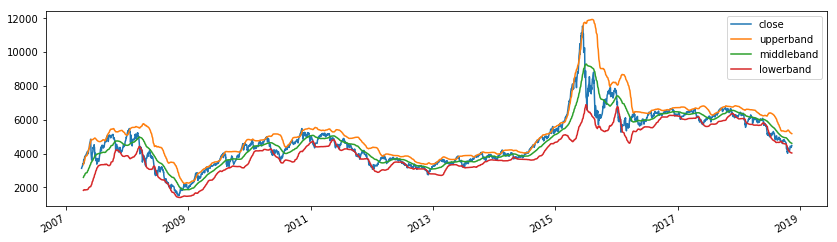

In [19]:
boll_df[['close', 'upperband', 'middleband', 'lowerband']].plot(figsize=(14,4))

In [20]:
import matplotlib.pyplot as plt  

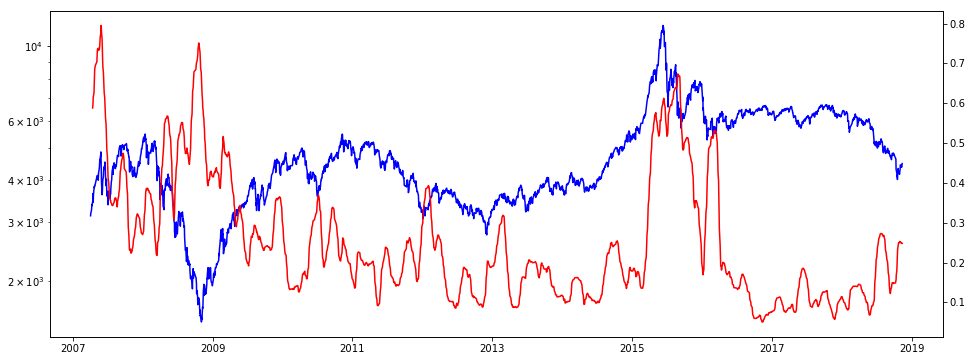

In [21]:
# 观察波动率与行情之间的关系
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
ax1.semilogy(boll_df.index, boll_df['close'], color='blue', label='close')
# ax1.plot(boll_df.index, boll_df['close'], color='red', label='close')


ax2 = ax1.twinx()
ax2.plot(boll_df.index, boll_df['bodonglv'], color='red', label='close')

plt.show()

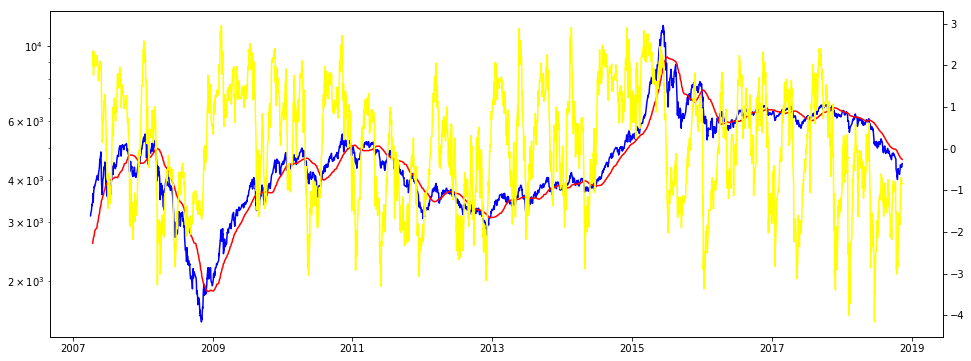

In [15]:
# close与均线的zscore，用于判断是否处于超跌状态
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
# ax1.plot(boll_df.index, boll_df['close'], color='blue', label='close')
ax1.semilogy(boll_df.index, boll_df['close'], color='blue', label='close')
ax1.semilogy(boll_df.index, boll_df['middleband'], color='red', label='close')

ax2 = ax1.twinx()
ax2.plot(boll_df.index, boll_df['zscore'], color='yellow', label='close')

plt.show()

# 通过对上面图的观察，挑选参数作为初步的判断
# 如果计算的标准分大于2.5分，判断为超涨状态，有可能行情会产生短期下跌
# 如果计算的标准分小于-3分，判断为超跌状态，可能行情会产生短期超跌反弹

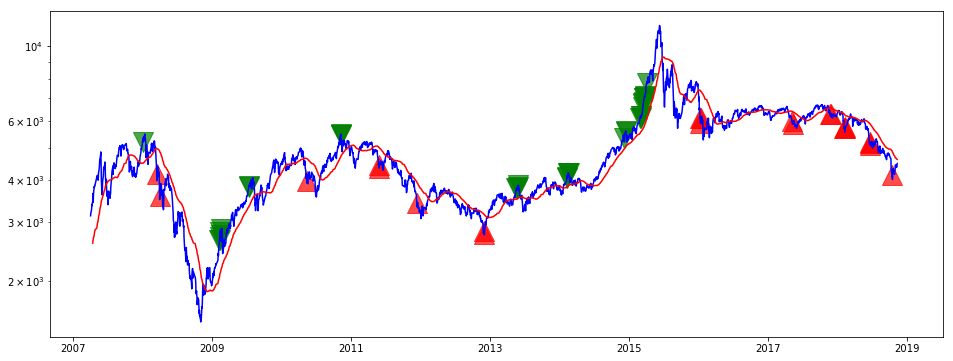

In [13]:
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
# ax1.plot(boll_df.index, boll_df['close'], color='blue', label='close')
ax1.semilogy(boll_df.index, boll_df['close'], color='blue', label='close')
ax1.semilogy(boll_df.index, boll_df['middleband'], color='red', label='close')

buy_flag_df = boll_df[boll_df['zscore'] < -3]
for index, row in buy_flag_df.iterrows():
    plt.scatter(index, row['close'], marker='^', color ='red', alpha=0.7, s=400, label = 'x3 samples')
    
sell_flag_df = boll_df[boll_df['zscore'] > 2.5]
for index, row in sell_flag_df.iterrows():
    plt.scatter(index, row['close'], marker='v', color ='green', alpha=0.7, s=400, label = 'x3 samples')

# ax2 = ax1.twinx()
# ax2.plot(boll_df.index, boll_df['zscore'], color='yellow', label='close')

plt.show()

# 通过上图对价格标准分大于2.5与小于3的位置进行标注
# 发现在判断超涨的状态并不理想，对于判断超跌有一定预示作用，但是有一定超前，有可能再下跌一部分后，才产生短期反弹
# 此指标无法直接使用于短期择时，还需要进行后续研究

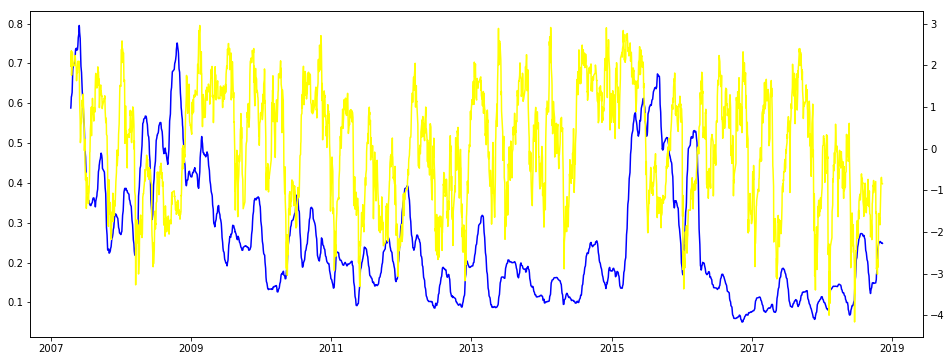

In [22]:
# 波动率与超跌状态之间的关系
fig = plt.figure(figsize=(16,6))
ax1 = fig.add_subplot(1,1,1)
ax1.plot(boll_df.index, boll_df['bodonglv'], color='blue', label='close')

ax2 = ax1.twinx()
ax2.plot(boll_df.index, boll_df['zscore'], color='yellow', label='close')

plt.show()